# Data transformation and augmentation

## Import librairies

In [1]:
import torch 
from torchvision import tv_tensors
from torchvision.io import read_image
from torchvision.transforms import v2
from torchvision.transforms.functional import to_pil_image, to_tensor
from PIL import Image
from torchvision import transforms as T
from torchvision.transforms import InterpolationMode
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms.functional as TF
from PIL import Image, ImageDraw
import math
import numpy as np

Functions

In [4]:
def load_labels(label_path):
    """Loads labels from a txt file and converts them to tensors."""
    labels = []
    boxes = []
    with open(label_path, 'r') as file:
        for line in file.readlines():
            cls, x_center, y_center, width, height = map(float, line.split())
            labels.append(int(cls))
            boxes.append([x_center, y_center, width, height])
    return torch.tensor(labels), torch.tensor(boxes)

def apply_transforms(image, boxes):
    """Applies transformations to the image and adjusts bounding boxes if necessary."""

    rotated_image = TF.rotate(image, 45)
    return rotated_image, boxes

def show_image_with_boxes(image, boxes, labels, class_names):
    """Displays the image with bounding boxes and labels."""
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    for box, label in zip(boxes, labels):
        # Convert the center x,y,width,height à xmin,ymin,xmax,ymax
        xmin = (box[0] - box[2] / 2) * image.width
        ymin = (box[1] - box[3] / 2) * image.height
        xmax = (box[0] + box[2] / 2) * image.width
        ymax = (box[1] + box[3] / 2) * image.height
        
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(xmin, ymin, class_names[label], color='blue', fontsize=12)

    plt.show()


def rotate_box(box, angle, image_width, image_height):
    """Rotates a bounding box by 'angle' degrees.

    Args:
        box (tensor): The bounding box, format [x_center, y_center, width, height].
        angle (float): The rotation angle in degrees, counter-clockwise.
        image_width (int): Width of the image.
        image_height (int): Height of the image.

    Returns:
        tensor: The rotated bounding box.
    """
    # Convert angle to radians
    angle_rad = math.radians(angle)

    # Calculate the rotation matrix
    cos_val = math.cos(angle_rad)
    sin_val = math.sin(angle_rad)
    rotation_matrix = np.array([[cos_val, -sin_val], [sin_val, cos_val]])

    # Convert box to corners (top-left and bottom-right)
    x_center, y_center, width, height = box
    x_center_abs = x_center * image_width
    y_center_abs = y_center * image_height
    width_abs = width * image_width
    height_abs = height * image_height
    corners = np.array([
        [x_center_abs - width_abs / 2, y_center_abs - height_abs / 2],  # Top-left
        [x_center_abs + width_abs / 2, y_center_abs + height_abs / 2]   # Bottom-right
    ])

    # Move corners to origin (for rotation), rotate, and move back
    corners_centered = corners - np.array([image_width / 2, image_height / 2])
    corners_rotated = np.dot(corners_centered, rotation_matrix)
    corners_moved_back = corners_rotated + np.array([image_width / 2, image_height / 2])

    # Convert rotated corners back to box format
    x_min, y_min = corners_moved_back[0]
    x_max, y_max = corners_moved_back[1]
    new_width = x_max - x_min
    new_height = y_max - y_min
    new_x_center = x_min + new_width / 2
    new_y_center = y_min + new_height / 2

    # Normalize the coordinates
    new_box = [
        new_x_center / image_width, new_y_center / image_height,
        new_width / image_width, new_height / image_height
    ]
    return torch.tensor(new_box)

def apply_transforms(image, boxes):
    """Applies transformations to the image and adjusts the bounding boxes."""
    # image rotation
    angle =  15 # On definit l'angle de rotation ici
    rotated_image = TF.rotate(image, angle)

    # Ajust the bounding boxes
    transformed_boxes = [rotate_box(box, angle, image.width, image.height) for box in boxes]

    return rotated_image, torch.stack(transformed_boxes)


Representation

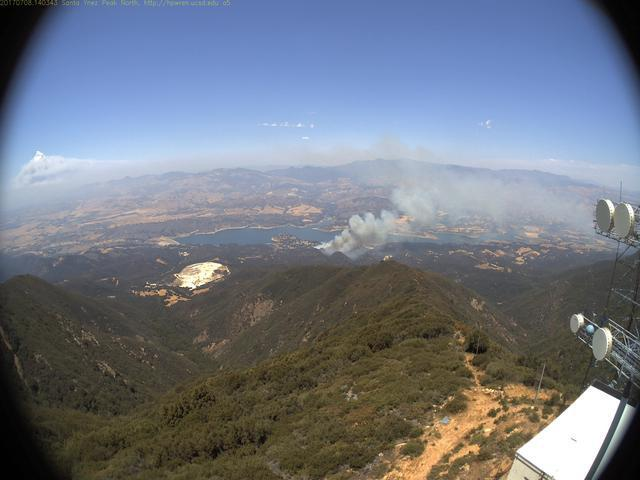

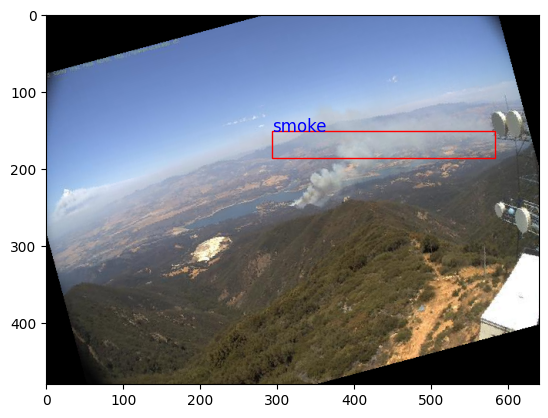

In [5]:
#Image and label location
image_path = "images/aiformankind_v1_000007.jpg"
label_path = "images/aiformankind_v1_000007.txt"

#Load the image
image = Image.open(image_path)

# Load the labels
class_names = ["smoke"]
labels, boxes = load_labels(label_path)


# Apply the transforms and show the iamage with the bouding boxes ajusted
transformed_image, transformed_boxes = apply_transforms(image, boxes)
display(image)
show_image_with_boxes(transformed_image, transformed_boxes, labels, class_names)